In [1]:
!pip install opencv-python-headless matplotlib scikit-learn albumentations tqdm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading and preprocessing images...


Processing Images: 100%|██████████| 1914/1914 [07:28<00:00,  4.27it/s]



Total loaded images: 1913


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Saving preprocessed images...
Preprocessed images saved to: /content/drive/MyDrive/cv-dataset/Leaves_preprocessed


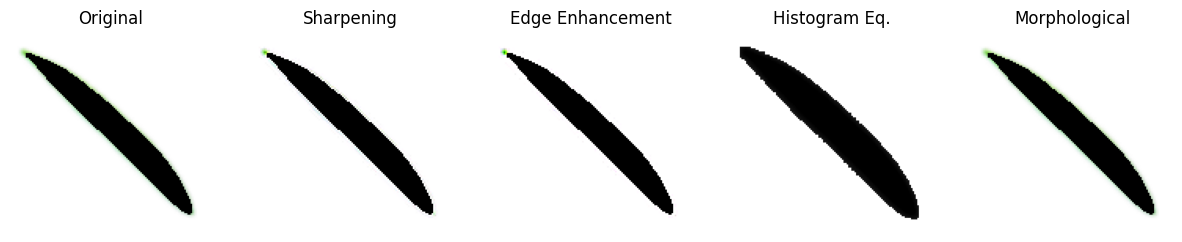

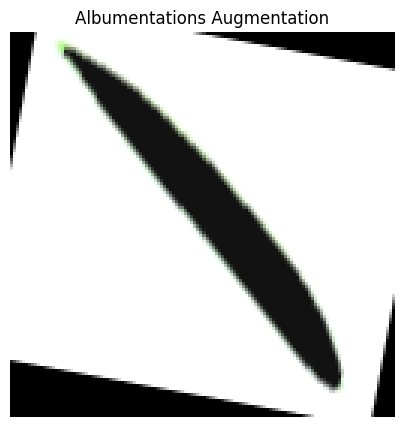

In [2]:
# -- coding: utf-8 --
"""cv-project.ipynb"""


from google.colab import drive
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import albumentations as A

# Mount Drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/cv-dataset/Leaves"
OUTPUT_DIR = "/content/drive/MyDrive/cv-dataset/Leaves_preprocessed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

X, y = [], []
print("Loading and preprocessing images...")

for img_name in tqdm(os.listdir(DATASET_DIR), desc="Processing Images"):
    img_path = os.path.join(DATASET_DIR, img_name)
    if not (img_name.lower().endswith(('.jpg', '.png', '.jpeg'))):
        continue
    try:
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = cv2.GaussianBlur(img, (5, 5), 0)

        # CLAHE
        lab = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l = clahe.apply(l)
        lab = cv2.merge((l, a, b))
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
        img = img / 255.0

        # Threshold background removal
        gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        mask = cv2.medianBlur(mask, 5)
        img[mask == 0] = 0

        X.append(img)
        y.append("leaf")
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

print(f"\nTotal loaded images: {len(X)}")

X = np.array(X)
y = np.array(y)

if len(X) > 0:
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
else:
    raise ValueError("No images were loaded! Check dataset path or image format.")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Additional Preprocessing Techniques
extra_preprocess = [
    ("Sharpening", np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])),
    ("Edge Enhancement", np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])),
]

aug = A.Compose([
    A.RandomBrightnessContrast(p=1.0),
    A.MotionBlur(blur_limit=3, p=1.0),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=1.0)
])

# Save preprocessed images
print("Saving preprocessed images...")
for i, img in enumerate(X_train):
    out_path = os.path.join(OUTPUT_DIR, f"leaf_{i}.jpg")
    cv2.imwrite(out_path, (img * 255).astype(np.uint8))
print(f"Preprocessed images saved to: {OUTPUT_DIR}")

# Display examples for each technique
sample = X_train[0]
plt.figure(figsize=(15, 6))
plt.subplot(1, 5, 1)
plt.imshow(sample)
plt.title("Original")
plt.axis('off')

# Sharpening and Edge Enhancement
for idx, (name, kernel) in enumerate(extra_preprocess, start=2):
    filtered = cv2.filter2D((sample * 255).astype(np.uint8), -1, kernel)
    plt.subplot(1, 5, idx)
    plt.imshow(filtered)
    plt.title(name)
    plt.axis('off')

# Histogram Equalization
gray = cv2.cvtColor((sample * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
hist_eq = cv2.equalizeHist(gray)
plt.subplot(1, 5, 4)
plt.imshow(hist_eq, cmap='gray')
plt.title("Histogram Eq.")
plt.axis('off')

# Morphological Opening
kernel = np.ones((3, 3), np.uint8)
morph = cv2.morphologyEx((sample * 255).astype(np.uint8), cv2.MORPH_OPEN, kernel)
plt.subplot(1, 5, 5)
plt.imshow(morph)
plt.title("Morphological")
plt.axis('off')

plt.show()

# Albumentations Example
augmented = aug(image=(sample * 255).astype(np.uint8))['image']
plt.figure(figsize=(5, 5))
plt.imshow(augmented)
plt.title("Albumentations Augmentation")
plt.axis('off')
plt.show()